# Initialisation

In [1]:
%matplotlib inline 
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import (
    create_eog_epochs,
    create_ecg_epochs,
    compute_proj_ecg,
    compute_proj_eog,
)
import sys
sys.path.append('/home/lucas/scikits-symbolic/symbolic')
import sequence as S
from discretize import partition
from algorithmic import lempel_ziv
from scipy import stats
import multiprocessing

# Importation des données : visual task and audio task

In [76]:
data_path = '/home/lucas/Documents/Data_MEG/sub-V1001/'
raw_file = data_path + 'meg/sub-V1001_task-visual_meg.ds'
raw_vis = mne.io.read_raw_ctf(raw_file)

# Affichage des informations sur les canaux
print(raw_vis.info)
raw_vis

ds directory : /home/lucas/Documents/Data_MEG/sub-V1001/meg/sub-V1001_task-visual_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.50   80.15    0.00 mm <->   -0.50   80.15    0.00 mm (orig :  -71.73   42.77 -259.14 mm) diff =    0.000 mm
       0.50  -80.15    0.00 mm <->    0.50  -80.15    0.00 mm (orig :   37.79  -74.15 -264.78 mm) diff =    0.000 mm
     108.63    0.00    0.00 mm <->  108.63   -0.00   -0.00 mm (orig :   62.71   58.11 -264.02 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 4 EEG channels from channel info
    4 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /home/lucas/Documents/Data_MEG/sub-V1001/meg/sub-V1001_task-visual_meg.ds/sub-V1001_task-visual_meg.meg4: 
    System clock channel is a

<RawCTF | sub-V1001_task-visual_meg.meg4, 352 x 4832825 (4027.4 s), ~582 kB, data not loaded>

In [3]:
data_path = '/home/lucas/Documents/Data_MEG/sub-A2002/'
raw_file = data_path + 'meg/sub-A2002_task-auditory_meg.ds'
raw_aud = mne.io.read_raw_ctf(raw_file)

# Affichage des informations sur les canaux
print(raw_aud.info)
raw_aud

ds directory : /home/lucas/Documents/Data_MEG/sub-A2002/meg/sub-A2002_task-auditory_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.11   70.36    0.00 mm <->   -0.11   70.36   -0.00 mm (orig :  -59.89   43.11 -252.20 mm) diff =    0.000 mm
       0.11  -70.36    0.00 mm <->    0.11  -70.36   -0.00 mm (orig :   33.94  -61.66 -256.89 mm) diff =    0.000 mm
     105.30    0.00    0.00 mm <->  105.29   -0.00    0.00 mm (orig :   64.88   59.46 -237.21 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /home/lucas/Documents/Data_MEG/sub-A2002/meg/sub-A2002_task-auditory_meg.ds/sub-A2002_task-auditory_meg.meg4: 
    System clock channe

<RawCTF | sub-A2002_task-auditory_meg.meg4, 356 x 2948754 (2457.3 s), ~588 kB, data not loaded>

# Prepocessing

In [77]:
raw_vis.crop(0, 300).pick_types(meg='mag', stim=True, eeg=True, eog=True).load_data()

#raw_aud.crop(0, 600).pick_types(meg='mag', stim=True, eeg=True, eog=True).load_data() 

Reading 0 ... 360000  =      0.000 ...   300.000 secs...


<RawCTF | sub-V1001_task-visual_meg.meg4, 308 x 360001 (300.0 s), ~846.5 MB, data loaded>

In [4]:
raw_vis.filter(l_freq=1, h_freq=None)
#raw_aud.filter(l_freq=1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3961 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:    2.8s finished


<RawCTF | sub-V1001_task-visual_meg.meg4, 308 x 360001 (300.0 s), ~846.5 MB, data loaded>

In [5]:
freqs = [50]
meg_picks_vis = mne.pick_types(raw_vis.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')
raw_vis.notch_filter(freqs=freqs, picks=meg_picks_vis, method='spectrum_fit', filter_length='10s')
#meg_picks_aud = mne.pick_types(raw_aud.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')
#raw_aud.notch_filter(freqs=freqs, picks=meg_picks_aud, method='spectrum_fit', filter_length='10s')

Removed notch frequencies (Hz):
     50.00 : 17759 windows


<RawCTF | sub-V1001_task-visual_meg.meg4, 308 x 360001 (300.0 s), ~846.5 MB, data loaded>

## ICA

In [78]:
ica = mne.preprocessing.ICA(n_components=70)
ica.fit(raw_vis)

Fitting ICA to data using 277 channels (please be patient, this may take a while)
Removing 5 compensators from info because not all compensation channels were picked.


/tmp/ipykernel_4351/978845007.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_vis)


Selecting by number: 70 components
Fitting ICA took 161.3s.


<ICA | raw data decomposition, method: fastica (fit in 93 iterations on 360001 samples), 70 ICA components (277 PCA components available), channel types: mag, eeg, no sources marked for exclusion>

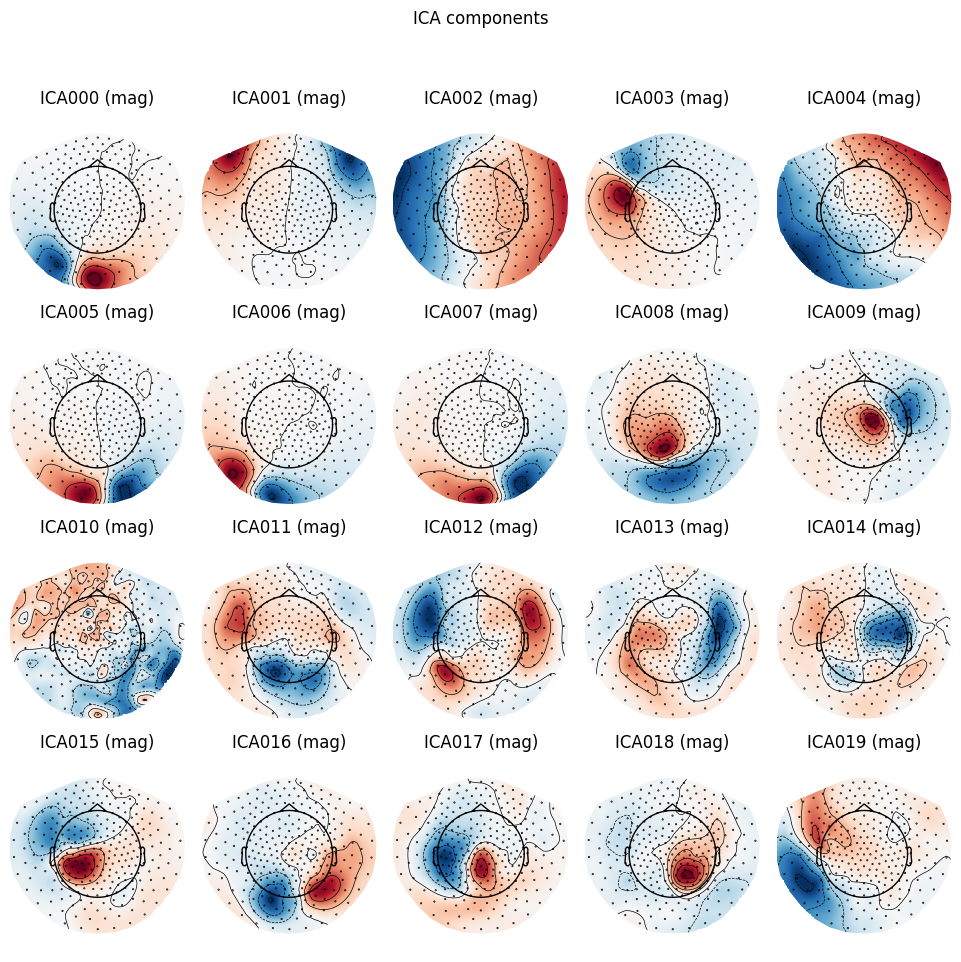

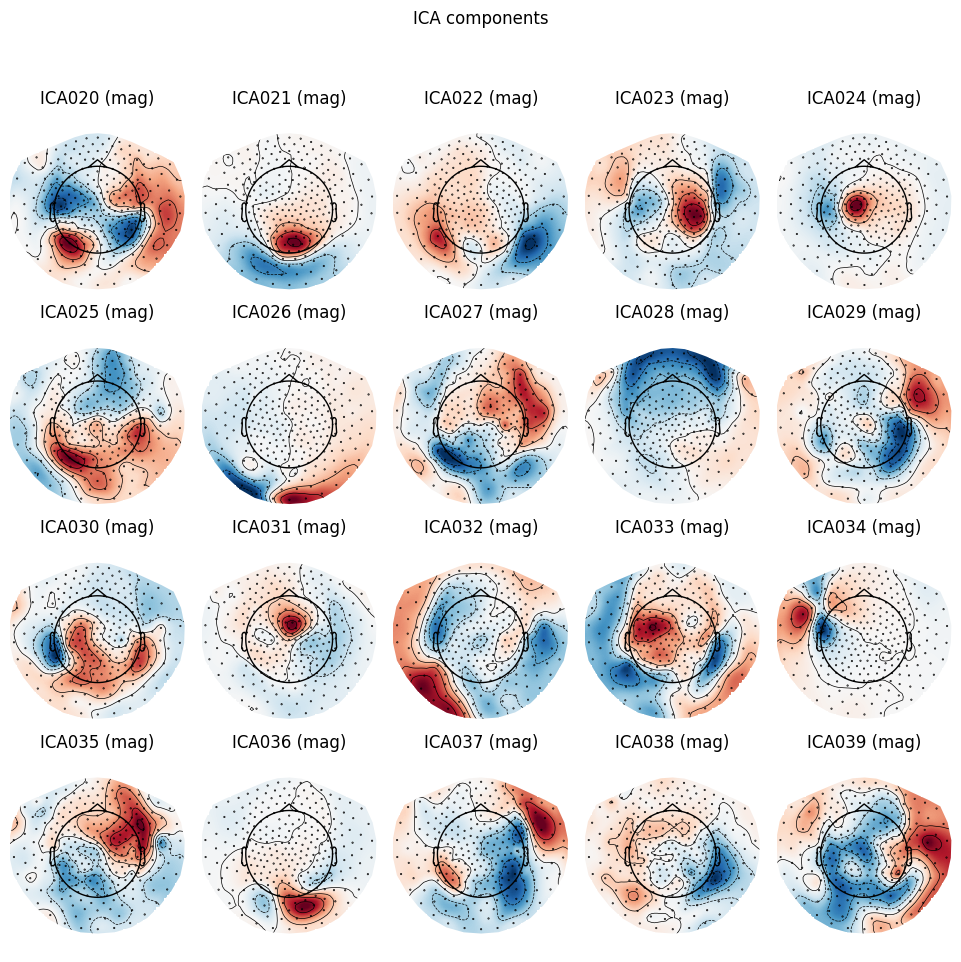

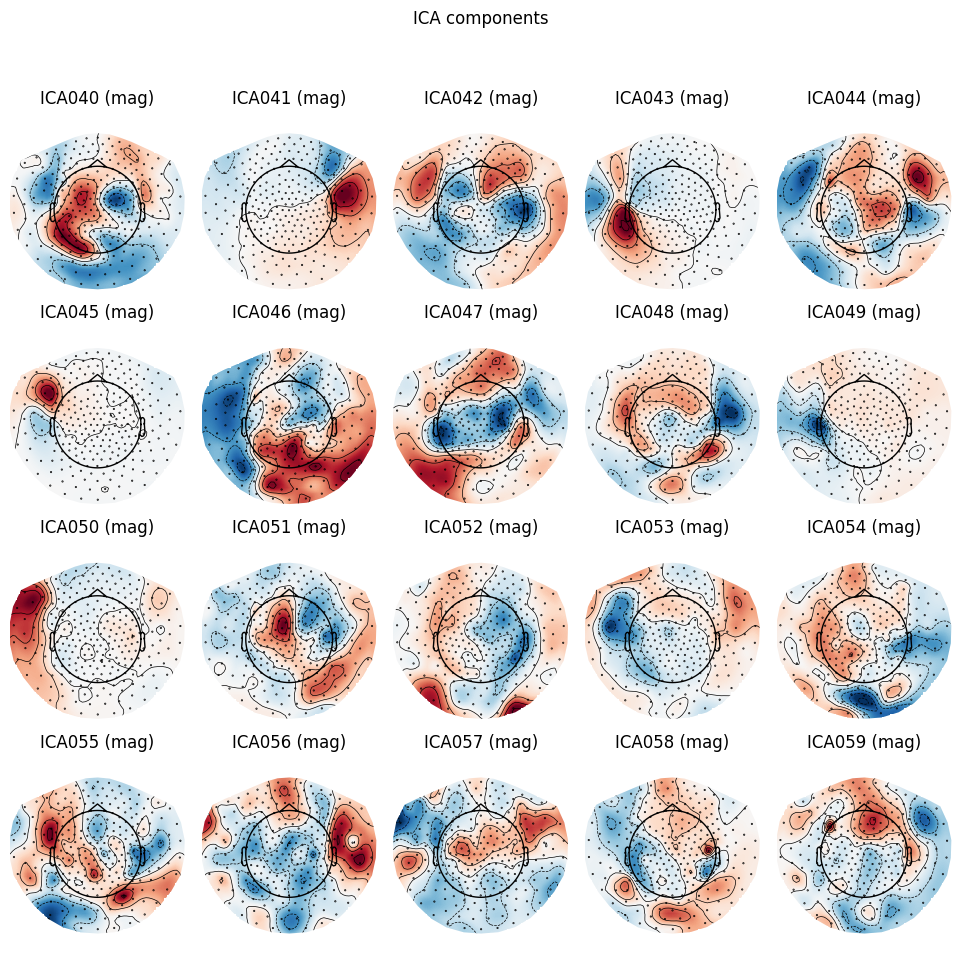

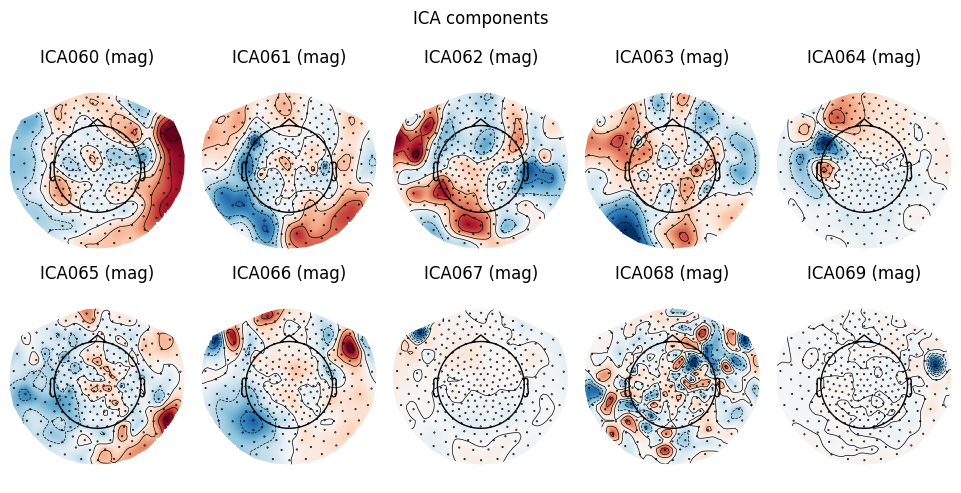

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x496 with 10 Axes>]

In [15]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=70, n_times=360001
    Range : 0 ... 360000 =      0.000 ...   300.000 secs
Ready.
Using matplotlib as 2D backend.


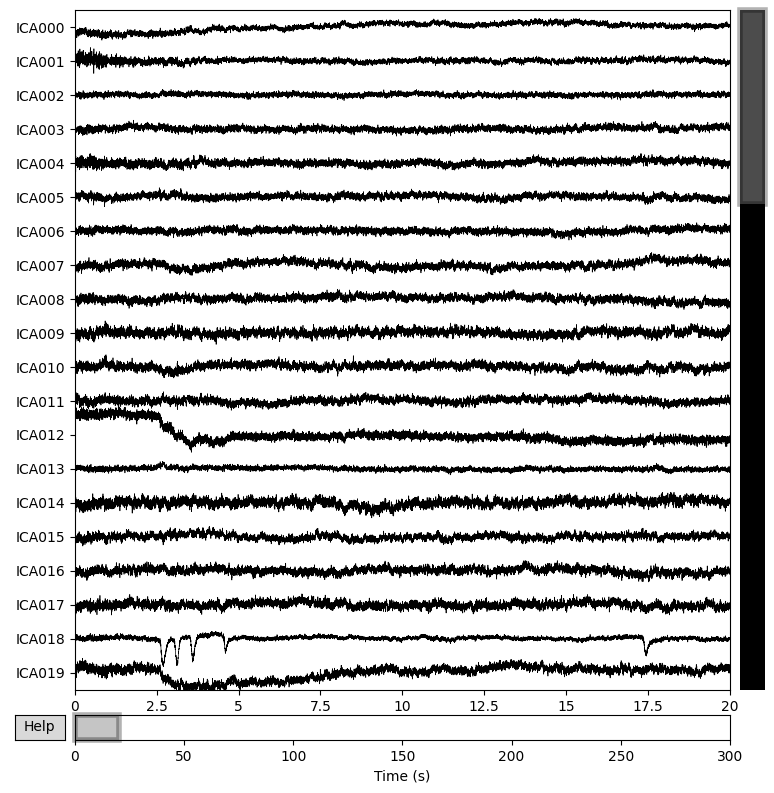

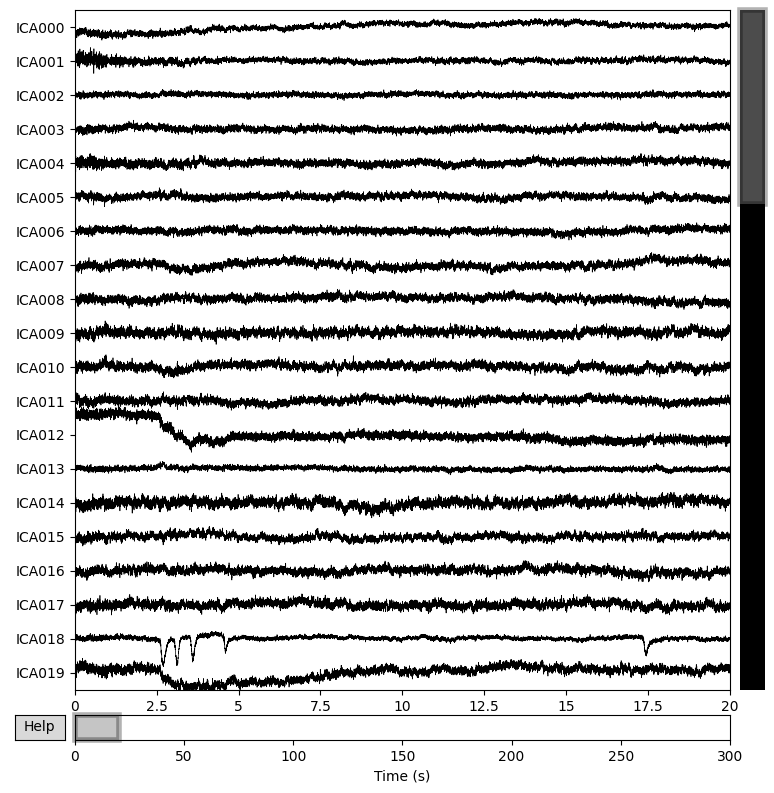

In [79]:
ica.plot_sources(raw_vis)

In [80]:
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_vis, ch_name="EEG059", method='correlation', threshold='auto')
eog_indices, eog_scores = ica.find_bads_eog(raw_vis, ch_name=["EEG057", "EEG058"])

... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 12000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 12000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Using EOG channels: EEG057, EEG058
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [81]:
art = list(set(eog_indices + ecg_indices))
art.sort()
print(f"Ocular artefacts {eog_indices}")
print(f"Cardiac artefacts {ecg_indices}")
print(f"All automatically detected artefacts {art}")

Ocular artefacts [18, 43, 6, 13]
Cardiac artefacts [15, 26, 32]
All automatically detected artefacts [6, 13, 15, 18, 26, 32, 43]


In [82]:
ica.exclude = art

In [ ]:
ica.plot_components()

In [83]:
ica.apply(raw_vis)

Applying ICA to Raw instance
    Transforming to ICA space (70 components)
    Zeroing out 7 ICA components
    Projecting back using 277 PCA components


<RawCTF | sub-V1001_task-visual_meg.meg4, 308 x 360001 (300.0 s), ~846.5 MB, data loaded>

## SSP

In [6]:
projs_vis, events_vis = compute_proj_ecg(raw_vis, n_grad=1, n_mag=1, n_eeg=1, reject=None, ch_name="EEG059")
raw_vis.add_proj(projs_vis, remove_existing=False)
eog_projs_vis, _ = compute_proj_eog(raw_vis, ch_name=["EEG057", "EEG058"],n_grad=1, n_mag=1, n_eeg=1, reject=None, no_proj=False)
raw_vis.add_proj(eog_projs_vis, remove_existing=False)
raw_vis.apply_proj()

Including 0 SSP projectors from raw file
Running ECG SSP computation
Using channel EEG059 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 12000 samples (10.000 sec)

Number of ECG events detected : 523 (average pulse 104 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 523 events and 721 original time points ...


[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:    4.7s finished


0 bad epochs dropped
No gradiometers found. Forcing n_grad to 0
Adding projection: axial--0.200-0.400-PCA-01
Adding projection: eeg--0.200-0.400-PCA-01
Done.
2 projection items deactivated
Including 2 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EEG057, EEG058
EOG channel index for this subject is: [304 305]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 45 significant peaks
Number

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
45 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data from preloaded Raw for 45 events and 481 original time points ...


[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:    4.6s finished


0 bad epochs dropped
No gradiometers found. Forcing n_grad to 0
Adding projection: axial--0.200-0.200-PCA-01
Adding projection: eeg--0.200-0.200-PCA-01
Done.
4 projection items deactivated
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...


<RawCTF | sub-V1001_task-visual_meg.meg4, 308 x 360001 (300.0 s), ~846.5 MB, data loaded>

# Epoching

## Auditory task

In [55]:
events_aud = mne.find_events(raw_aud, stim_channel='UPPT001', verbose=True)

320 events found
Event IDs: [ 1  2  3  4  5  6  7  8 10 11 12 14 15 20 40]


In [59]:
event_id = {
    'onset/sentence/RC+sentence/individual_word': 1,
    'onset/sentence/RC+sentence/target_word': 2,
    'onset/sentence/RC-sentence/individual_word': 5,
    'onset/sentence/RC-sentence/target_word': 6,
    'onset/word_list/RC-sentence/individual_word': 7,
    'onset/word_list/RC-sentence/target_word': 8,
    'instruction/word_or_sentence': 10,
    'Audio start' : 14,
    'offset': 15,
    'pre-trial_baseline': 20,
    'question': 40
}

/tmp/ipykernel_45515/868201639.py:1: RuntimeWarning: event 3 missing from event_id will be ignored
  fig = mne.viz.plot_events(events_aud, sfreq=raw_aud.info['sfreq'],
/tmp/ipykernel_45515/868201639.py:1: RuntimeWarning: event 4 missing from event_id will be ignored
  fig = mne.viz.plot_events(events_aud, sfreq=raw_aud.info['sfreq'],
/tmp/ipykernel_45515/868201639.py:1: RuntimeWarning: event 11 missing from event_id will be ignored
  fig = mne.viz.plot_events(events_aud, sfreq=raw_aud.info['sfreq'],
/tmp/ipykernel_45515/868201639.py:1: RuntimeWarning: event 12 missing from event_id will be ignored
  fig = mne.viz.plot_events(events_aud, sfreq=raw_aud.info['sfreq'],
/tmp/ipykernel_45515/868201639.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events_aud, sfreq=raw_aud.info['sfreq'],


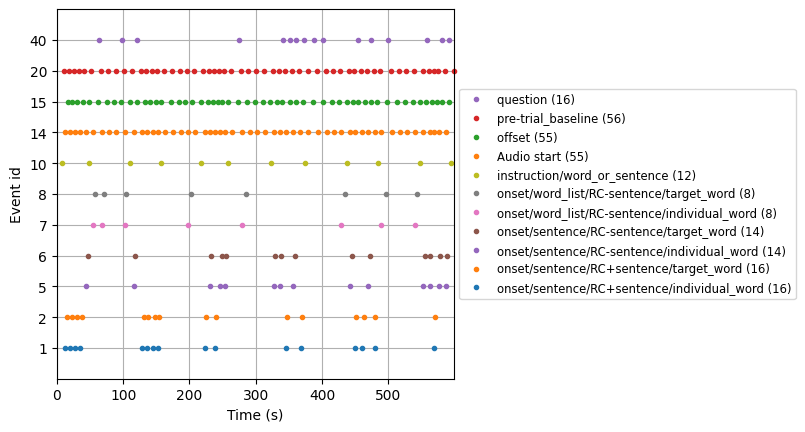

In [60]:
fig = mne.viz.plot_events(events_aud, sfreq=raw_aud.info['sfreq'],
                          event_id=event_id)

In [94]:
event_id = {
    '1': 1,
    '2': 2,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '10': 10,
    'W': 14,
    'E': 15,
    'B':20
}

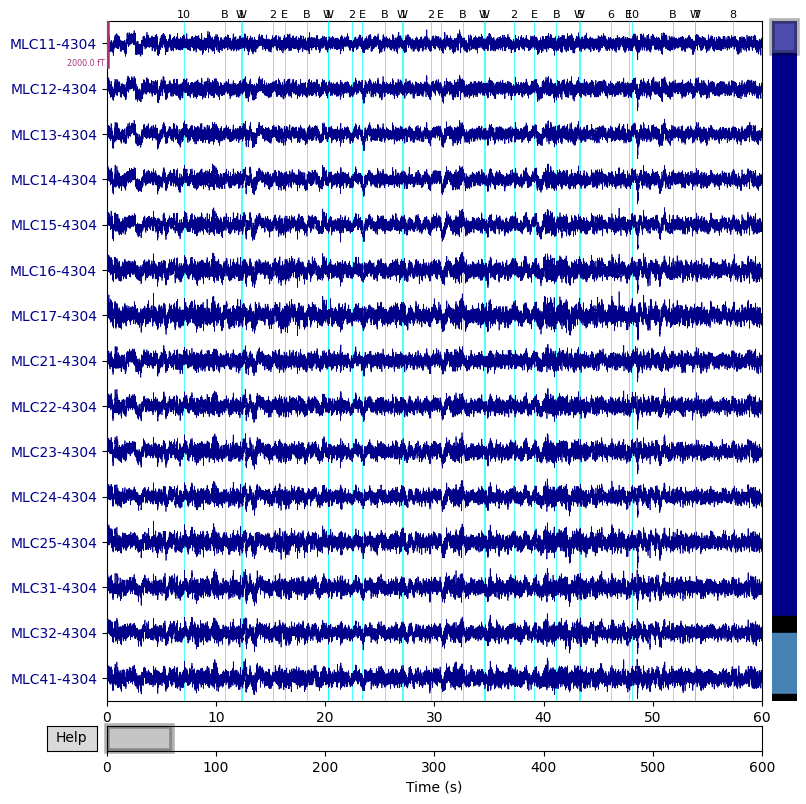

In [95]:
raw_aud.plot(duration=60, n_channels=15, event_id=event_id, events=events_aud);

In [113]:
start = events_aud[events_aud[:,2] == 14]
end = events_aud[events_aud[:,2] == 15]
duree = (end - start)/raw_aud.info['sfreq']

print(np.max(duree), np.mean(duree))

9.611666666666666 1.9333434343434344


In [142]:
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 10 # end of each epoch
baseline = (-0.2, 0)  # means from 200ms before to stim onset (t = 0)

## Visual task

In [84]:
events_vis = mne.find_events(raw_vis, stim_channel='UPPT001', verbose=True)

541 events found
Event IDs: [ 1  2  5  6  7  8 10 15 20 40]


In [24]:
event_id = {
    'onset/sentence/RC+/individual_word': 1,
    'onset/sentence/RC+/target_word': 2,
    #'onset/word_list/RC+/individual_word' : 3,
    #'onset/word_list/RC+/target_word' : 4,
    'onset/sentence/RC-/individual_word': 5,
    'onset/sentence/RC-/target_word': 6,
    'onset/word_list/RC-/individual_word': 7,
    'onset/word_list/RC-/target_word': 8,
    'instruction/word_or_sentence': 10,
    'offset': 15,
    'pre-trial_baseline': 20,
    'question': 40
}

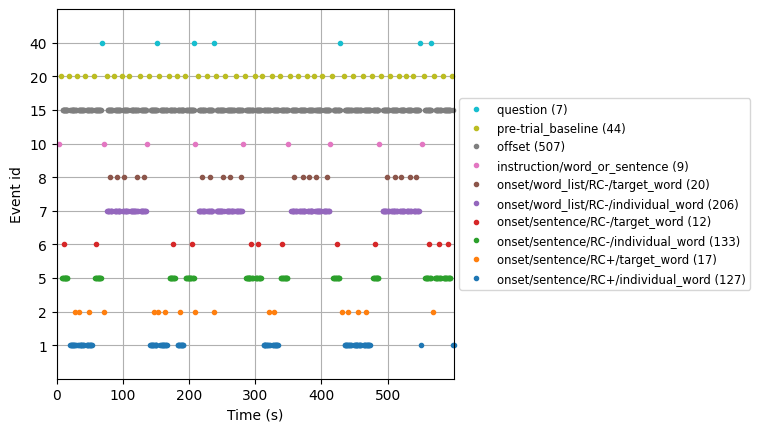

In [10]:
fig = mne.viz.plot_events(events_vis, sfreq=raw_vis.info['sfreq'],
                          event_id=event_id)

In [49]:
event_id = {
    '1': 1,
    '2': 2,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    'B': 10,
    'E': 15,
    'S': 20
}

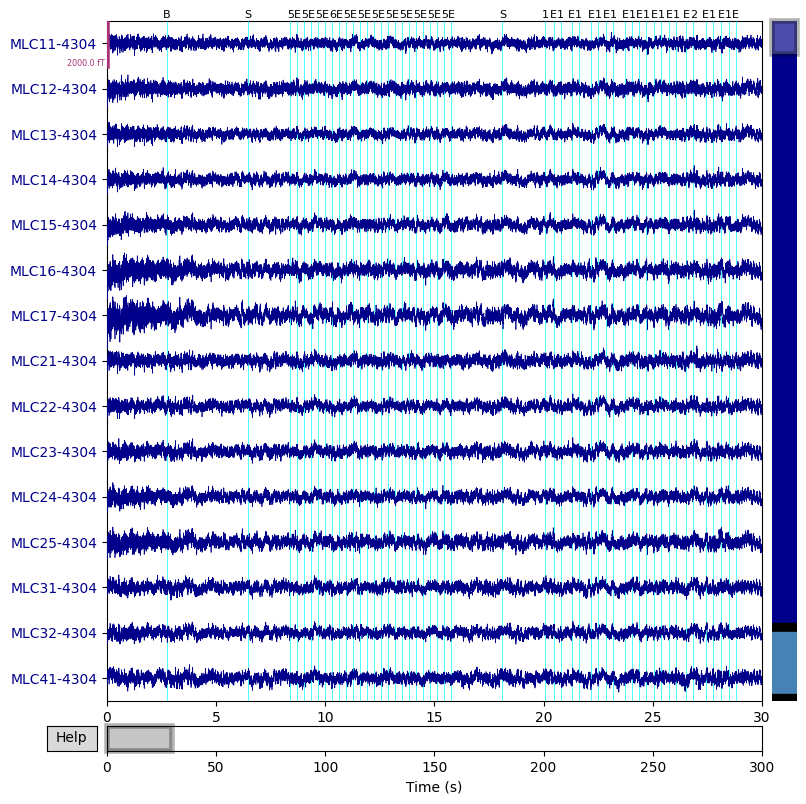

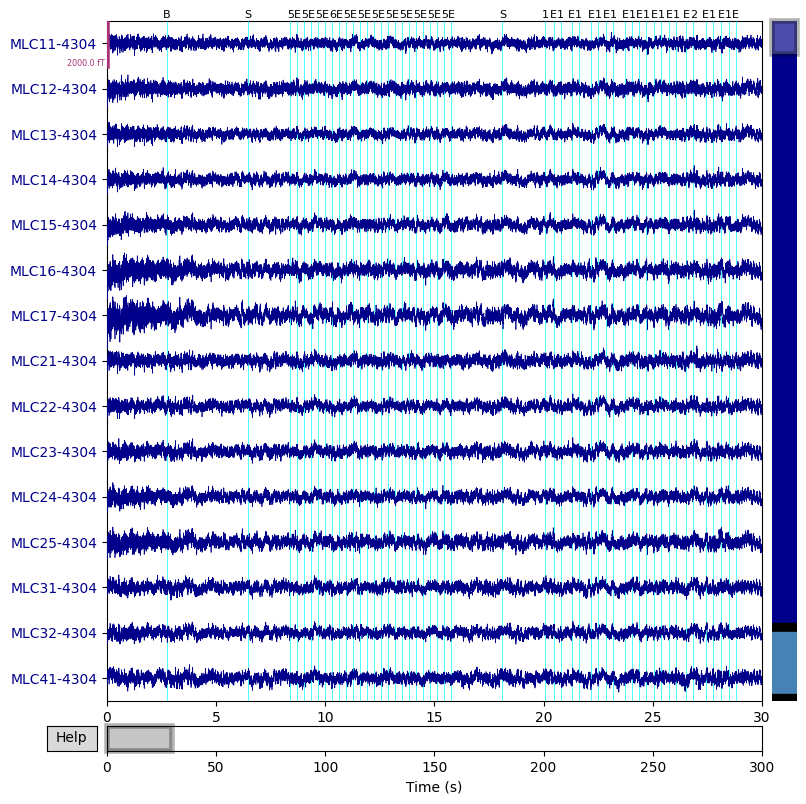

In [53]:
raw_vis.plot(duration=30, n_channels=15, event_id=event_id, events=events_vis)

# Fonctions

In [7]:
def epochs_phrase_liste(events):
    """
    :param events: events object 
    """
    phrases_simples = []
    phrases_complexes = []
    listes = []
    for i in range(len(events)-1):
        if events[i,2]==5 or events[i,2]==6:
            phrases_simples.append(events[i])
            phrases_simples.append(events[i+1])
        elif events[i,2]==7 or events[i,2]==8:
                listes.append(events[i])
                listes.append(events[i+1])
        elif events[i,2]==1 or events[i,2]==2:
                phrases_complexes.append(events[i])
                phrases_complexes.append(events[i+1])
    return phrases_simples, phrases_complexes, listes

def ecart_event(events, raw):
    duree = []
    for i in range(len(events)-1):
        duree.append(np.abs(events[i+1][0] - events[i][0]))
    return np.array(duree)/raw.info['sfreq']

def separation_phrase(events, raw):
    intervalles = [0]
    liste_events = []
    for i in range(len(events)-1):
        if np.array(np.abs(events[i+1][0] - events[i][0]))/raw.info['sfreq'] > 3:
            intervalles.append(i+1)
    for j in range(len(intervalles)-1):
        liste_events.append(events[intervalles[j]:intervalles[j+1]])
    return(liste_events)

def remove_false_sentence(events):
    indices = []
    for i in range(len(events)):
        if len(events[i]) < 5:
            indices.append(i)
    indices.sort(reverse=True)
    for el in indices:
        del(events[el])
    return(events)

In [58]:
def epoching(raw, events, tmin, tmax, events_id=None):
    picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')
    epochs = mne.Epochs(raw, events, events_id, tmin, tmax, proj=True,
                    picks=picks, baseline=None)
    epochs.load_data()
    return epochs
    
def SVD(data, k):
    ":param k: Le nombre de vecteurs propres que l'on veut garder pour obtenir une représentation réduite de nos données"
    data = data.T
    U, Valeurs_propres, VT = np.linalg.svd(data, full_matrices=False)
    S = np.diag(Valeurs_propres)
    reduced_data = np.dot(U[:, k], np.dot(S[k], VT[k, :].T))
    return (reduced_data.T)

def calcul_entropy(raw, liste, tmin=-0.8, tmax=0.8):
    h = []
    for el in liste:
        epochs = epoching(raw_vis, el, tmin, tmax)
        h_phrase = Epoch_to_entropyrate(epochs, 2)
        h.append(h_phrase)
    return(h)

def Epoch_to_entropyrate(epoch, nb_symb):
    entropy_list = []
    M = epoch.get_data()
    for i in range(len(M)):
        M_SVD = SVD(M[i])
        H = Signal_to_entropyrate(M_SVD, nb_symb)
        entropy_list.append(H)
    return(np.array(entropy_list))

def Signal_to_entropyrate(data, nb_symb):
    """
    Create a symbolic sequence from all the channel of the MEG signal then return a list with the associated entropy rates of the sequences.
    
    :param data: the matrix of the MEG signal, the rows correspond to the channels and the columns correspond to the time
    :param nb_symb: The number of symbol that we want to create symbolic sequences from the temporal sequences of all the channels with equipartition

    """
    seq = partition(data, nbin=nb_symb)
    entropy_rate = lempel_ziv(seq)
    return np.array(entropy_rate)

def fenetre_glissante(reduced_data, taille_fenetre, ecart_fenetre, nb_symb):
    pas = 0
    h = []
    nb_points = len(reduced_data)
    for i in range(nb_points//ecart_fenetre):
        if pas + taille_fenetre <= nb_points:
            fenetre = reduced_data[pas:pas+taille_fenetre]
            h_fenetre = Signal_to_entropyrate(fenetre, nb_symb)
            h.append(h_fenetre)
            pas += ecart_fenetre
    return(h)

In [9]:
def mean_std(h_liste):
    for i in range(len(h_liste)):
        h_liste[i] = np.mean(h_liste[i])
    return(np.mean(h_liste), np.std(h_liste))

In [63]:
def delimitation_stimuli(liste_phrase, taille_fenetre):
    marqueurs_temporels = []
    for i in range(len(liste_phrase)):
        bornes = []
        premier = liste_phrase[i][0][0]%taille_fenetre
        if premier > taille_fenetre//2 :
            bornes.append(liste_phrase[i][0][0] + (taille_fenetre - premier))
        else :
            bornes.append(liste_phrase[i][0][0] - premier)
        dernier = liste_phrase[i][-1][0]%taille_fenetre
        if dernier > taille_fenetre//2 :
            bornes.append(liste_phrase[i][-1][0] + (taille_fenetre - dernier))
        else :
            bornes.append(liste_phrase[i][-1][0] - dernier)
        marqueurs_temporels.append(bornes)
    return (marqueurs_temporels)

def correspondance_fenetre_temps(h_temps, taille_fenetre):
    x = []
    for i in range(len(h_temps)):
        x.append(taille_fenetre*i)
    return(np.array(x)+1000)

def temporal_colors(marqueurs_temporels, x):
    x_color = []
    for i in range(len(marqueurs_temporels)):
        intervalle = []
        for j in range(len(x)):
            if x[j] == marqueurs_temporels[i][0]:
                intervalle.append(j)
            if x[j] == marqueurs_temporels[i][1]:
                intervalle.append(j)
        x_color.append(x[intervalle[0]:intervalle[1]+1])
    return (x_color)

# Expérimentation

In [11]:
phrases_simples, phrases_complexes, listes_mots = epochs_phrase_liste(events_vis)

In [12]:
liste_phrases_complexes = separation_phrase(phrases_complexes, raw_vis)
liste_phrases_complexes = remove_false_sentence(liste_phrases_complexes)
liste_phrases_simples = separation_phrase(phrases_simples, raw_vis)
liste_phrases_simples = remove_false_sentence(liste_phrases_simples)
liste_listes_mots = separation_phrase(listes_mots, raw_vis)
liste_listes_mots = remove_false_sentence(liste_listes_mots)

## Entropie relatifs aux différentes conditions expérimentales

In [14]:
h_phrases_complexes = calcul_entropy(raw_vis, liste_phrases_complexes)

Not setting metadata
24 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 24 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
22 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 22 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
22 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 22 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
54 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 54 events and 1921 original time points ...
0 bad

In [15]:
h_phrases_simples = calcul_entropy(raw_vis, liste_phrases_simples)

Not setting metadata
24 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 24 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
24 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 24 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
22 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 22 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
30 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 30 events and 1921 original time points ...
0 bad

In [16]:
h_listes_mots = calcul_entropy(raw_vis, liste_listes_mots)

Not setting metadata
20 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 20 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
22 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 22 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 20 events and 1921 original time points ...
0 bad epochs dropped
Not setting metadata
28 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 28 events and 1921 original time points ...
0 bad

In [17]:
mean_simple, std_simple = mean_std(h_phrases_simples)
mean_complexe, std_complexe = mean_std(h_phrases_complexes)
mean_mots, std_mots = mean_std(h_listes_mots)

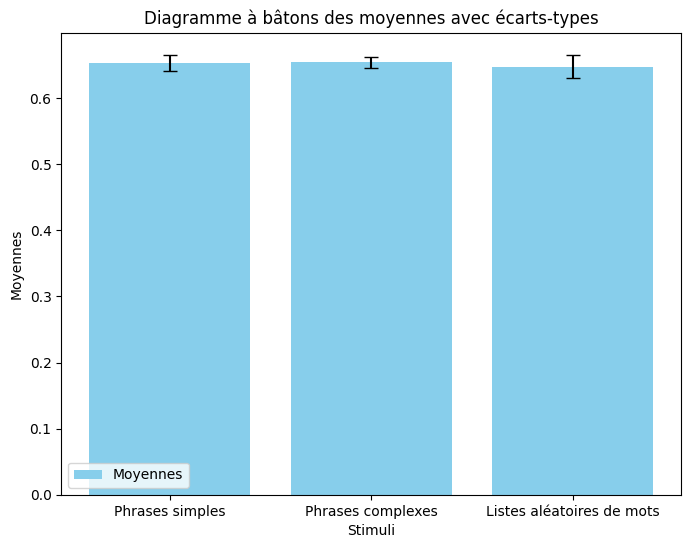

In [18]:
stimuli = ['Phrases simples', 'Phrases complexes', 'Listes aléatoires de mots']
moyennes = [mean_simple, mean_complexe, mean_mots]
ecart_types = [std_simple, std_complexe, std_mots]

# Créez une figure
plt.figure(figsize=(8, 6))

# Créez un diagramme à bâtons pour les moyennes
plt.bar(stimuli, moyennes, yerr=ecart_types, capsize=5, color='skyblue', label='Moyennes')

# Ajoutez des titres et des étiquettes
plt.xlabel('Stimuli')
plt.ylabel('Moyennes')
plt.title('Diagramme à bâtons des moyennes avec écarts-types')
plt.legend()

# Affichez le diagramme
plt.show()

## Entropie au cours du temps (fenêtre glissante)

In [80]:
picks = mne.pick_types(raw_vis.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')
M = raw_vis.get_data(picks)
M = SVD(M)
h_temps_visuelle = fenetre_glissante(M, 1000, 500, 2)

In [18]:
picks = mne.pick_types(raw_aud.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')
M = raw_aud.get_data(picks)
M = SVD(M)
h_temps_auditive = fenetre_glissante(M, 1000, 500, 2)

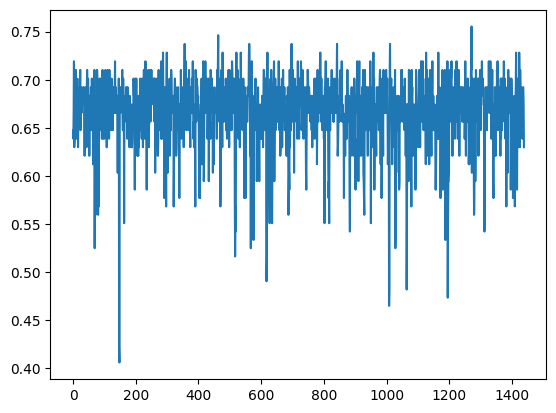

In [28]:
plt.plot(h_temps_visuelle)

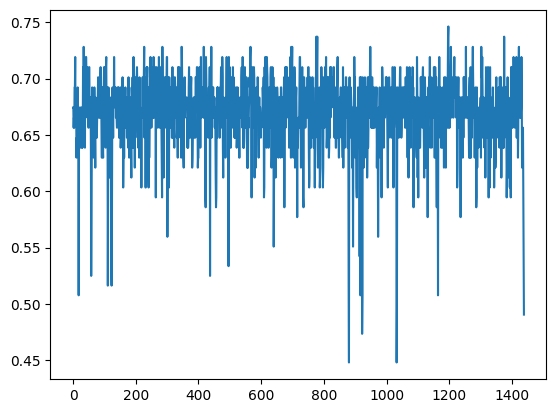

In [29]:
plt.plot(h_temps_auditive)

## Entropie au cours du temps - version finale

In [28]:
picks = mne.pick_types(raw_vis.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')
M = raw_vis.get_data(picks)

In [98]:
M_svd = SVD(M,1)
h_temps_visuelle2 = fenetre_glissante(M_svd, 1000, 1000, 4)

In [86]:
data = M.T
U, Valeurs_propres, VT = np.linalg.svd(data, full_matrices=False)
S = np.diag(Valeurs_propres)

In [87]:
reduced_data = []
for k in range(16):
    reduced_data.append(np.dot(U[:, k], np.dot(S[k], VT[k, :].T)))

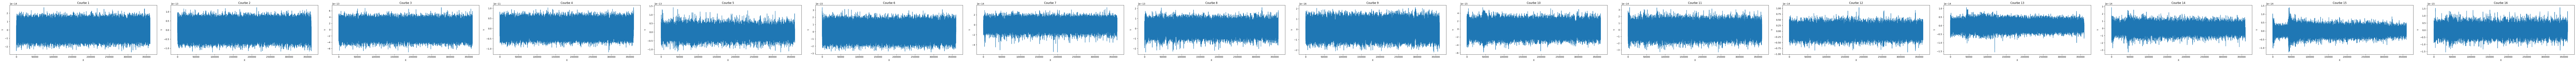

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=len(reduced_data), figsize=(10*len(reduced_data), 4))
for i, ax in enumerate(axs):
    ax.plot(reduced_data[i])
    ax.set_title(f'Courbe {i + 1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()

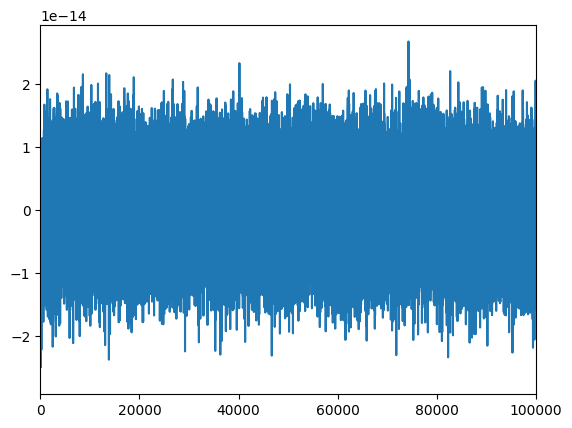

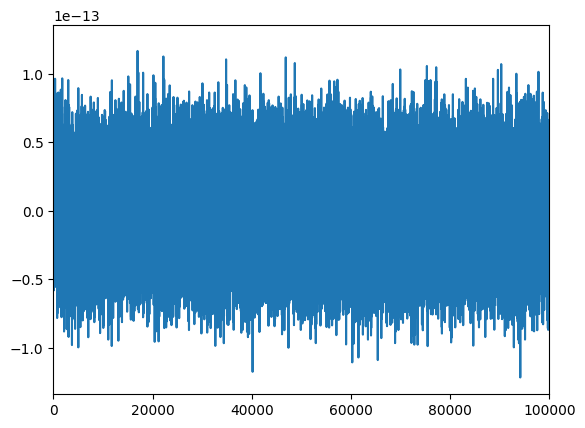

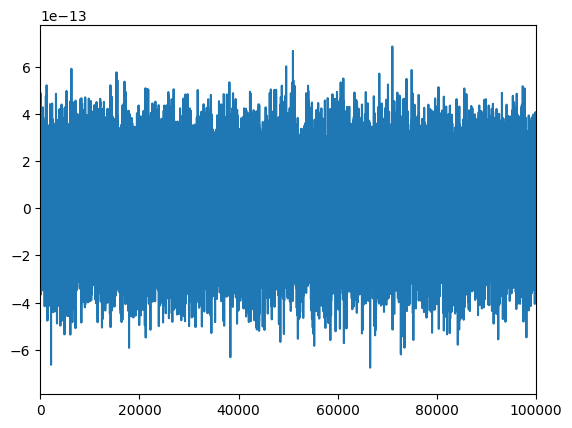

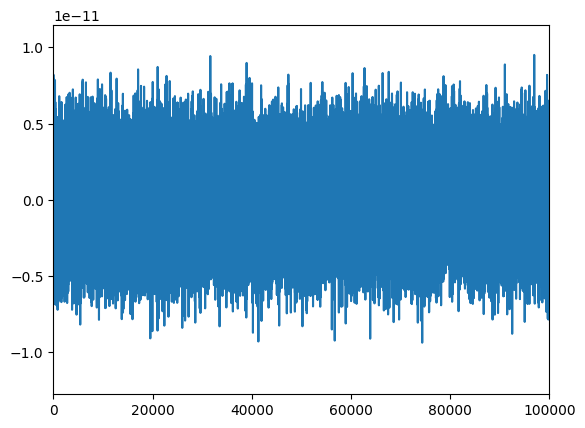

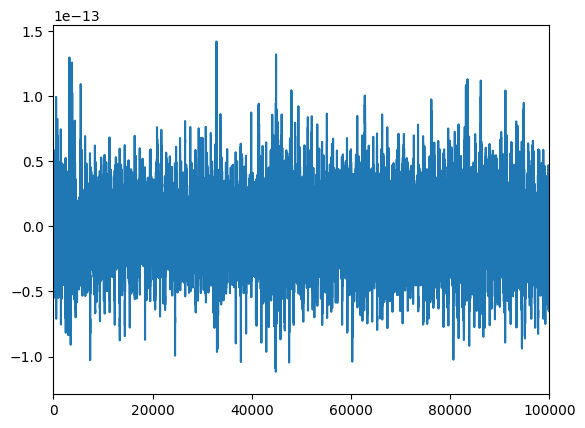

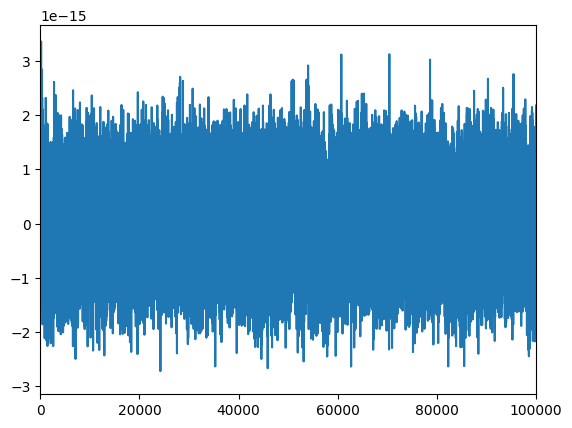

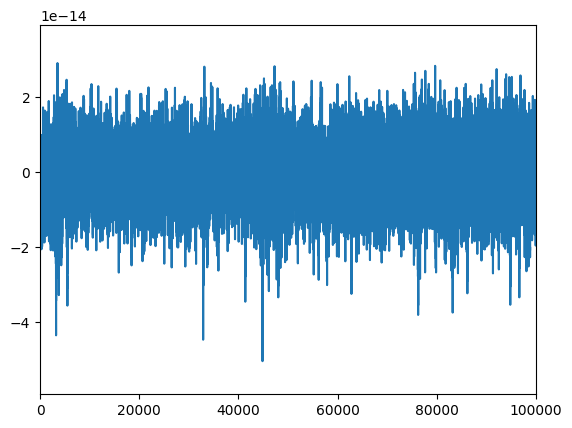

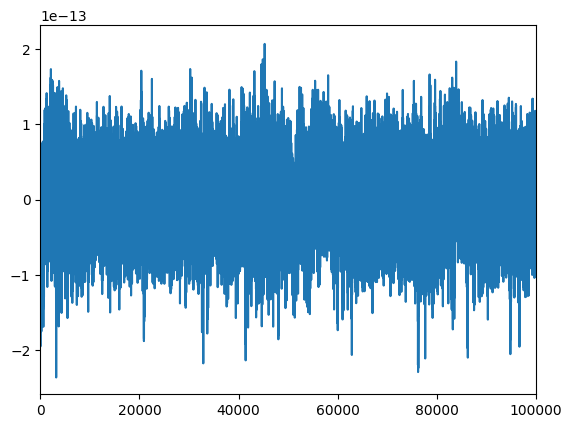

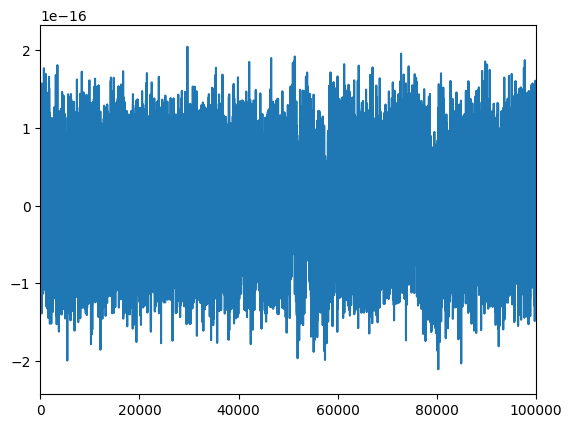

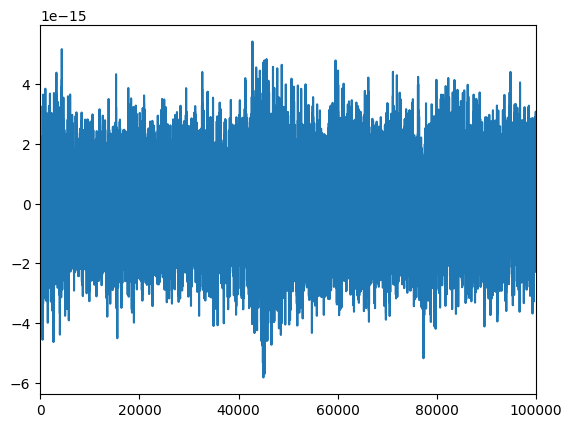

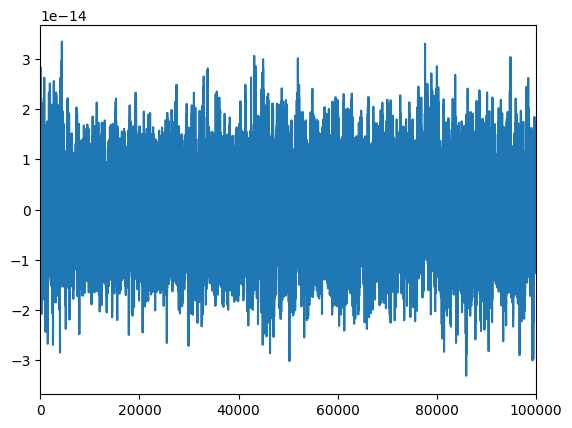

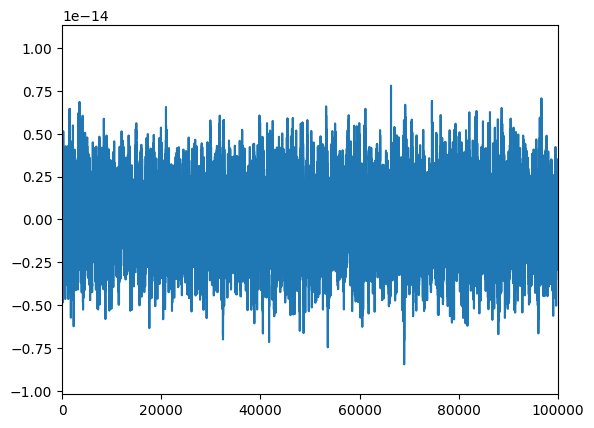

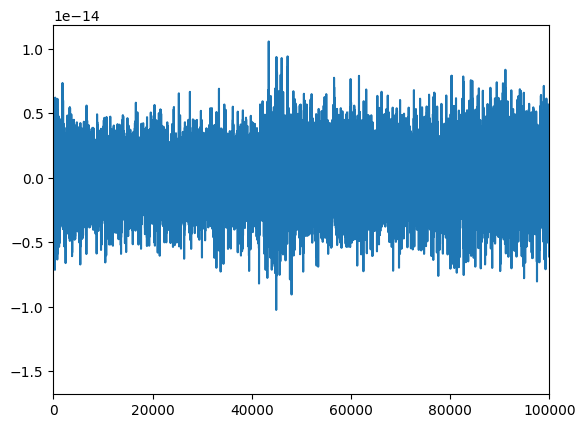

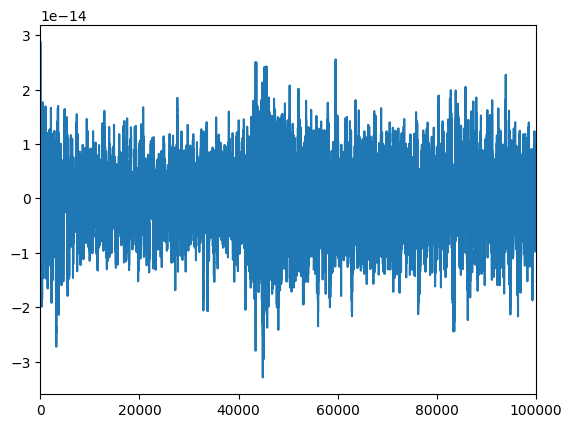

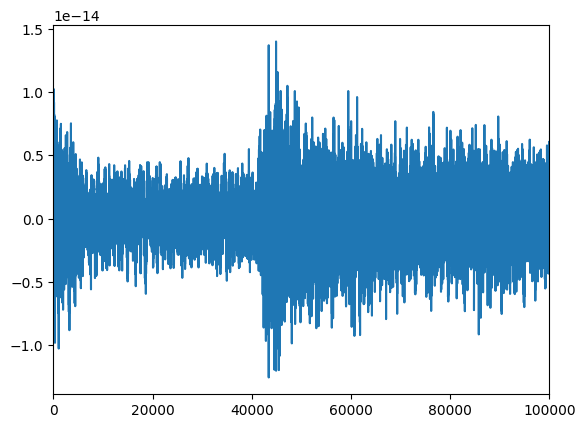

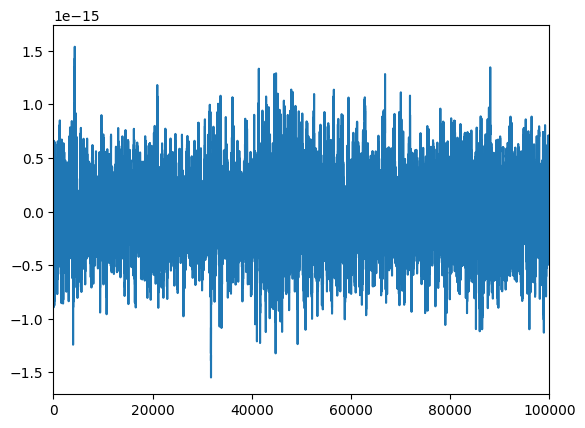

In [88]:
for i in range(len(reduced_data)):
    plt.figure()
    plt.plot(reduced_data[i])
    plt.xlim(0,100000)
plt.show()

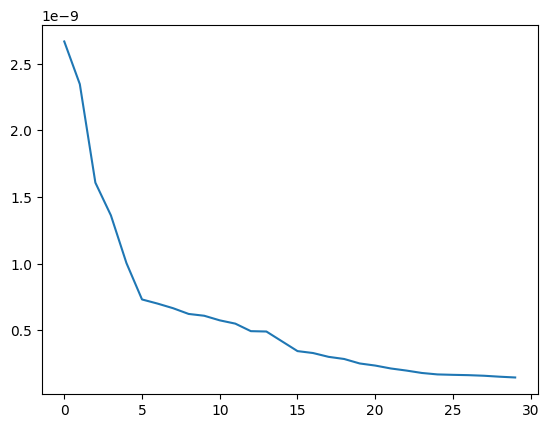

In [22]:
plt.plot(Valeurs_propres[:30])

In [99]:
marqueurs_phrases_simples = delimitation_stimuli(liste_phrases_simples, 1000)
marqueurs_phrases_complexes = delimitation_stimuli(liste_phrases_complexes, 1000)
marqueurs_listes_mots = delimitation_stimuli(liste_listes_mots, 1000)

In [100]:
x = correspondance_fenetre_temps(h_temps_visuelle2, 1000)

In [101]:
x_simple = temporal_colors(marqueurs_phrases_simples, x)
x_complexe = temporal_colors(marqueurs_phrases_complexes, x)
x_liste_mots = temporal_colors(marqueurs_listes_mots, x)

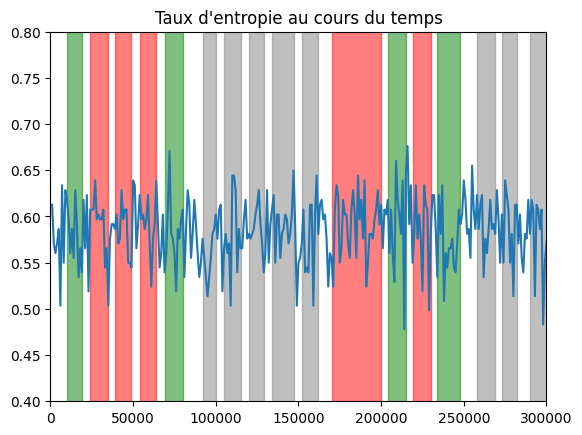

In [103]:
plt.plot(x, h_temps_visuelle2)
couleur_simple = 'green'
label_simple = 'Phrases simples'
couleur_complexe = 'red'
label_complexe = 'Phrases complexes'
couleur_liste_mots = 'grey'
label_liste_mots = 'Liste de mots'
for interval in x_simple:
    plt.fill_between(interval, 0, 1, color=couleur_simple, alpha=0.5, label=label_simple)
for interval in x_complexe:
    plt.fill_between(interval, 0, 1, color=couleur_complexe, alpha=0.5, label=label_complexe)
for interval in x_liste_mots:
    plt.fill_between(interval, 0, 1, color=couleur_liste_mots, alpha=0.5, label=label_liste_mots)
plt.title("Taux d'entropie au cours du temps")
plt.xlim(0,300000)
plt.ylim(0.4,0.8)
plt.show()